In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import scipy
import h5py
from PIL import Image
from scipy import ndimage
from dnn_app_utils_v3 import *

In [2]:
np.random.seed(1)

In [3]:
# Loading datasets

train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

# Statistics

print("Number of training examples " + str(train_x_orig.shape[0]))
print("Number of testing examples " + str(test_x_orig.shape[0]))
print("Size of each image " + str(train_x_orig.shape[1]) + ", " + str(train_x_orig.shape[1]) + ", 3")

Number of training examples 209
Number of testing examples 50
Size of each image 64, 64, 3


In [4]:
# We need to reshape and standardize the images before feeding them to the network. We'll reshape each image consisting
# of three layers (for each RGB) into single vector.

train_x = train_x_orig.reshape(train_x_orig.shape[0], -1).T / 255
test_x =  test_x_orig.reshape(test_x_orig.shape[0], -1).T / 255

# 255 is since pixels take values from 0 to 255

### 2-Layer architecture of the model

The input in this model is a (64, 64, 3) image which is flattened to a vector of size (12288, 1). The corresponding
vector is than transposed and multiplied by the weight matrix $ W^{l} $ of size ($ n^{l}, 12288 $). Then we add a bias
term and take its ReLU to get the following vector:
$ \begin{bmatrix} a^{1}_0 & a_1^1 & \dots & a_{n - 1}^1 \end{bmatrix}^T $. We repeat the same process after. Then we
multiply the resulting vector by $ W^2 $ and add the intercept (bias). Finally, we take the sigmoid function of the
result. If the result greater than $ 0.5 $, we classify it as a cat.

### L-layer deep neural network

The input, the multiplication of resulting vector by weight matrix and adding bias are the same steps as in 2-layer
model. Next step is to take *ReLU* of the linear unit (the result of multiplication and addition). This process could be
repeated several times for each $ W^{l}, b^{l} $ depending on the model architecture. Finally, we take the sigmoid of
the final linear unit. Classification happens as before.

### General methodology

1. Initialization of parameters and definition of hyperparameters;
2. Loop though:
    - Forward propagation;
    - Computation of cost function;
    - Backward propagation;
    - Updating parameters;
3. Using trained parameters to predict labels

In [5]:
# Constants defining the model and that are used in 2-layer model

number_of_features = 12288
number_of_h = 7     # What's h?
number_of_y = 1     # What's y?
layers_dimensions_2 = (number_of_features, number_of_h, number_of_y)

In [6]:
def sigmoid(z):

    a = 1 / (1 + np.exp(-z))
    cache = z

    return a, cache

In [7]:
def relu(z):

    a = np.maximum(0, z)
    cache = z

    return a, cache

In [8]:
def backward_sigmoid(d_activation, cache):

    z = cache
    s = 1 / (1 + np.exp(-z))
    dz = d_activation * s * (1 - s)

    return dz

In [9]:
def backward_relu(d_activation, cache):

    z = cache
    dz = np.array(d_activation, copy = True)
    dz[z <= 0] = 0

    return dz

In [10]:
def initialize_parameters(n_x, n_h, n_y):

    np.random.seed(1)

    w1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    w2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))

    param = {"W1": w1, "b1": b1, "W2": w2, "b2": b2}

    return param

In [11]:
def update_parameters(param, gradients, learning_rate):

    number_of_layers = len(param) // 2

    for i in range(number_of_layers):
        param["W" + str(i + 1)] = param["W" + str(i + 1)] - learning_rate * gradients["dW" + str(i + 1)]
        param["b" + str(i + 1)] = param["b" + str(i + 1)] - learning_rate * gradients["db" + str(i + 1)]

    return param

In [12]:
def linear_forward_propagation(activations, weights, bias):

    z = weights.dot(activations) + bias
    cache = (activations, weights, bias)

    return z, cache

In [13]:
def linear_activation_forward_propagation(activations_previous, weights, bias, activation):

    z, linear_cache = linear_forward_propagation(activations_previous, weights, bias)

    if activation == "sigmoid":
        activations, activation_cache = sigmoid(z)
    else:
        activations, activation_cache = relu(z)

    cache = (linear_cache, activation_cache)

    return activations, cache

In [14]:
def linear_backward_propagation(dz, cache):

    activation_previous, weights, bias = cache
    m = activation_previous.shape[1]

    dw = 1 / m * np.dot(dz, activation_previous.T)
    db = 1 / m * np.sum(dz, axis = 1, keepdims = True)
    d_activation_previous = np.dot(weights.T, dz)

    return d_activation_previous, dw, db

In [15]:
def linear_activation_backward_propagation(d_activation, cache, activation):

    linear_cache, activation_cache = cache

    if activation == "sigmoid":
        dz = backward_sigmoid(d_activation, activation_cache)
    else:
        dz = backward_relu(d_activation, activation_cache)

    d_activation_previous, dw, db = linear_backward(dz, linear_cache)

    return d_activation_previous, dw, db

In [16]:
def compute_cost(probability_vector, label_vector):

    tests = label_vector.shape[1]
    cost = -1 / tests * (np.dot(label_vector, np.log(probability_vector.T)) +
                         np.dot(1 - label_vector, np.log(1 - probability_vector).T))

    return cost

In [17]:
def visualization_of_cost(costs, learning_rate):

    plt.plot(np.squeeze(costs))
    plt.ylabel("Cost")
    plt.xlabel("Iterations")
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

In [18]:
# This part is used for 2-layer model

def two_layer_model(x, y, dims, learning_rate = 0.0075, number_of_iterations = 3000, print_cost = False):

    """
    :param x: input data, of shape (number_of_features, number of examples)
    :param y: true "label" vector, of shape (1, number of examples)
    :param dims: dimensions of the layers
    :param learning_rate: learning rate of the gradient descent update rule
    :param number_of_iterations: number of iterations of the optimization loop
    :param print_cost: if set to True, than will print the cost every 100 iterations
    :return: parameters - a dictionary containing W1, W2, b1, and b2
    """

    np.random.seed(1)

    gradients = {}
    costs = []   # to keep track of the cost
    (n_f, n_h, n_y) = dims

    params = initialize_parameters(n_f, n_h, n_y)

    w1 = params["W1"]
    w2 = params["W2"]
    b1 = params["b1"]
    b2 = params["b2"]

    for i in range(0, number_of_iterations):

        # Forward propagation: linear - ReLU - linear - sigmoid
        a1, cache1 = linear_activation_forward_propagation(x, w1, b1, activation = "relu")
        a2, cache2 = linear_activation_forward_propagation(a1, w2, b2, activation = "sigmoid")

        # Computing cost function
        cost = compute_cost(a2, y)

        # Initialization of backward propagation
        da2 = - (np.divide(y, a2) - np.divide(1 - y, 1 - a2))

        # Backward propagation
        da1, dw2, db2 = linear_activation_backward_propagation(da2, cache2, activation = "sigmoid")
        da0, dw1, db1 = linear_activation_backward_propagation(da1, cache1, activation = "relu")

        gradients["dW1"] = dw1
        gradients["dW2"] = dw2
        gradients["db1"] = db1
        gradients["db2"] = db2

        # Updating parameters
        params = update_parameters(params, gradients, learning_rate)

        # Retrieving updated parameters
        w1 = params["W1"]
        w2 = params["W2"]
        b1 = params["b1"]
        b2 = params["b2"]

        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)

    # Plotting the cost
    visualization_of_cost(costs, learning_rate)

    return params

Cost after iteration 0: 0.693049735659989
Cost after iteration 100: 0.6464320953428849
Cost after iteration 200: 0.6325140647912678
Cost after iteration 300: 0.6015024920354665
Cost after iteration 400: 0.5601966311605748
Cost after iteration 500: 0.515830477276473
Cost after iteration 600: 0.4754901313943325
Cost after iteration 700: 0.43391631512257495
Cost after iteration 800: 0.40079775362038866
Cost after iteration 900: 0.3580705011323798
Cost after iteration 1000: 0.3394281538366413
Cost after iteration 1100: 0.3052753636196264
Cost after iteration 1200: 0.27491377282130164
Cost after iteration 1300: 0.24681768210614857
Cost after iteration 1400: 0.19850735037466094
Cost after iteration 1500: 0.17448318112556632
Cost after iteration 1600: 0.17080762978096875
Cost after iteration 1700: 0.11306524562164708
Cost after iteration 1800: 0.09629426845937152
Cost after iteration 1900: 0.08342617959726867
Cost after iteration 2000: 0.07439078704319087
Cost after iteration 2100: 0.06630748

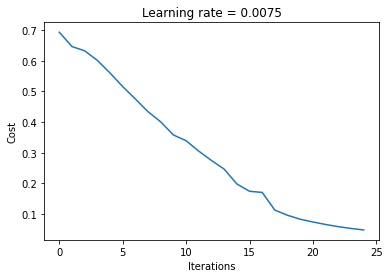

In [19]:
parameters = two_layer_model(train_x, train_y, dims = (number_of_features, number_of_h, number_of_y),
                             number_of_iterations = 2500, print_cost = True)

In [20]:
prediction_train = predict(train_x, train_y, parameters)
prediction_test = predict(test_x, test_y, parameters)

Accuracy: 0.9999999999999998
Accuracy: 0.72


In [21]:
# Constants that are used in the n-layer model

layers_dimensions_n = [12288, 20, 7, 5, 1]    # 4-layer model

In [22]:
def initialize_parameters_depp(dims):

    np.random.seed(1)

    param = {}
    number_of_layers = len(dims)

    for i in range(1, number_of_layers):
        param['W' + str(i)] = np.random.randn(dims[i], dims[i - 1]) / np.sqrt(dims[i - 1])
        param['b' + str(i)] = np.zeros((dims[i], 1))

    return param

In [23]:
def l_layer_forward_propagation(x, param):

    caches = []
    activation = x
    number_of_layers = len(param) // 2

    # Implementation of [linear - ReLU] * (number_of_layers - 1)
    for i in range(1, number_of_layers):
        previous_activation = activation
        activation, cache = linear_activation_forward_propagation(previous_activation, param['W' + str(i)],
                                                                  param['b' + str(i)], activation = "relu")
        caches.append(cache)

    # Implementation of linear - sigmoid
    last_activation, cache = linear_activation_forward_propagation(activation, param['W' + str(number_of_layers)],
                                                       param['b' + str(number_of_layers)], activation = "sigmoid")
    caches.append(cache)

    return last_activation, caches

In [24]:
def l_layer_backward_propagation(last_activation, y, caches):

    grads = {}
    number_of_layers = len(caches)
    y = y.reshape(last_activation.shape)     # y is the same shape as last_activation

    # Initializing the backpropagation
    d_last_activation = - (np.divide(y, last_activation) - np.divide(1 - y, 1 - last_activation))

    # Lth layer (SIGMOID -> LINEAR) gradients
    current_cache = caches[number_of_layers - 1]
    grads["dA" + str(number_of_layers - 1)], grads["dW" + str(number_of_layers)], grads["db" + str(number_of_layers)] = linear_activation_backward_propagation(d_last_activation, current_cache, activation = "sigmoid")

    for i in reversed(range(number_of_layers - 1)):
        # ith layer: (RELU -> LINEAR) gradients.
        current_cache = caches[i]
        da_prev_temp, dw_temp, db_temp = linear_activation_backward_propagation(grads["dA" + str(i + 1)], current_cache,
                                                                    activation = "relu")
        grads["dA" + str(i)] = da_prev_temp
        grads["dW" + str(i + 1)] = dw_temp
        grads["db" + str(i + 1)] = db_temp

    return grads

In [25]:
def l_layer_model(x, y, dims, learning_rate = 0.0075, number_of_iterations = 3000, print_cost = True):

    """
    :param x: input data, of shape (number_of_features, number of examples)
    :param y: true "label" vector, of shape (1, number of examples)
    :param dims: dimensions of the layers
    :param learning_rate: learning rate of the gradient descent update rule
    :param number_of_iterations: number of iterations of the optimization loop
    :param print_cost: if set to True, than will print the cost every 100 iterations
    :return: parameters - a dictionary containing W1, W2, b1, and b2
    """

    np.random.seed(1)

    costs = []

    # Parameters initialization
    params = initialize_parameters_depp(dims)

    # Calculating gradient descent
    for i in range(0, number_of_iterations):

        # Forward propagation: [linear - ReLU] * (number_of_layers - 1) - linear - sigmoid
        last_activation , caches = l_layer_forward_propagation(x, params)
        cost = compute_cost(last_activation, y)

        # Backward propagation
        gradients = l_layer_backward_propagation(last_activation, y, caches)

        params = update_parameters(params, gradients, learning_rate)

        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)

    visualization_of_cost(costs, learning_rate)

    return params

Cost after iteration 0: 0.7717493284237686
Cost after iteration 100: 0.6720534400822914
Cost after iteration 200: 0.6482632048575212
Cost after iteration 300: 0.6115068816101354
Cost after iteration 400: 0.5670473268366111
Cost after iteration 500: 0.5401376634547801
Cost after iteration 600: 0.5279299569455267
Cost after iteration 700: 0.4654773771766851
Cost after iteration 800: 0.36912585249592794
Cost after iteration 900: 0.39174697434805344
Cost after iteration 1000: 0.3151869888600617
Cost after iteration 1100: 0.2726998441789385
Cost after iteration 1200: 0.23741853400268137
Cost after iteration 1300: 0.19960120532208647
Cost after iteration 1400: 0.18926300388463305
Cost after iteration 1500: 0.1611885466582775
Cost after iteration 1600: 0.14821389662363316
Cost after iteration 1700: 0.1377748781297294
Cost after iteration 1800: 0.1297401754919012
Cost after iteration 1900: 0.12122535068005211
Cost after iteration 2000: 0.1138206066863371
Cost after iteration 2100: 0.1078392852

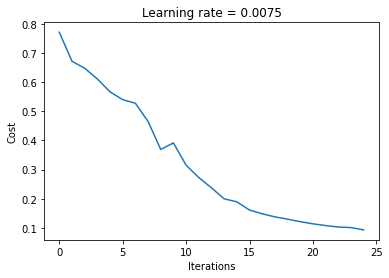

In [26]:
parameters = l_layer_model(train_x, train_y, layers_dimensions_n, number_of_iterations = 2500, print_cost = True)

In [27]:
prediction_test_deep = predict(train_x, train_y, parameters)
prediction_train_deep = predict(test_x, test_y, parameters)

Accuracy: 0.9856459330143539
Accuracy: 0.8
